## Unsequa for 2023-07-07

5d forecast so that subsampling might have an effect

In [29]:
from flood_model_paper import *


In [30]:
from climada.engine import ImpactCalc
from climada.entity import ImpactFunc, ImpactFuncSet, Exposures
from climada.engine.unsequa import CalcImpact, InputVar

from climada_petals.hazard.rf_glofas.river_flood_computation import RiverFloodInundation
from climada_petals.hazard.rf_glofas.transform_ops import save_file
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset


## Hazard

In [ ]:
rf = RiverFloodInundation()

dates = pd.date_range("2023-07-06", "2023-07-08")
for date in dates:
    date = date.date.isoformat()
    rf.download_forecast(
        "Pakistan",
        date,
        lead_time_days=5,
        preprocess=lambda x: x.max(dim="step"),
        system_version="operational",
    )
    ds_flood = rf.compute(resample_kws=dict(num_bootstrap_samples=20, num_workers=4))
    save_file(ds_flood, DATA_GEN_DIR / f"pakistan-flood-forecast-{date}.nc")
    rf.clear_cache()

## Exposure

In [31]:
from climada.entity import Exposures

exp = Exposures.from_raster(get_pakistan_worlpop_historical(2023))
exp.set_geometry_points()
exp.gdf = exp.gdf.loc[exp.gdf["value"] > 0, :]  # Only retain values > 0
exp.gdf["impf_RF"] = 1
exp.gdf


/Users/ldr.riedel/coding/climada_python/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


longitude   latitude     value                   geometry  impf_RF
1646     74.627916  37.095417  0.396374  POINT (74.62792 37.09542)        1
1647     74.636250  37.095417  0.596124  POINT (74.63625 37.09542)        1
1648     74.644583  37.095417  0.906110  POINT (74.64458 37.09542)        1
1649     74.652916  37.095417  1.069196  POINT (74.65292 37.09542)        1
1650     74.661250  37.095417  1.496682  POINT (74.66125 37.09542)        1
...            ...        ...       ...                        ...      ...
3266290  68.127916  23.703750  0.139919  POINT (68.12792 23.70375)        1
3266291  68.136250  23.703750  3.541304  POINT (68.13625 23.70375)        1
3266292  68.144583  23.703750  6.130545  POINT (68.14458 23.70375)        1
3266293  68.152916  23.703750  5.206255  POINT (68.15292 23.70375)        1
3266294  68.161250  23.703750  0.483914  POINT (68.16125 23.70375)        1

[1179859 rows x 5 columns]

## Unsequa

In [4]:
from climada.engine.unsequa import CalcImpact, InputVar


def run_unsequa(haz_input, impf_input, output_file):
    calc = CalcImpact(exp, impf_input, haz_input)
    out = calc.make_sample(1024)
    out = calc.uncertainty(out, rp=[], processes=4)
    out = calc.sensitivity(out)
    out.to_hdf5(output_file)


def impf_list_from_data(filename):
    df_impf = pd.read_json(filename)
    impf_list = [
        ImpactFuncSet(
            [
                ImpactFunc.from_step_impf(
                    haz_type="RF",
                    intensity=(0, row["threshold"], 100),
                    paa=(0, row["paa"]),
                )
            ]
        )
        for _, row in df_impf.iterrows()
    ]
    return InputVar.impfset(impf_list)

In [ ]:
from scipy.stats import randint
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset

for date in dates.date:
    for suffix in ("", "_flopros"):
        with xr.open_dataset(
            DATA_GEN_DIR / f"pakistan-flood-forecast-{date.isoformat()}.nc",
            chunks="auto",
        ) as ds:
            hazard_s = hazard_series_from_dataset(
                ds,
                intensity=f"flood_depth{suffix}",
                event_dim="number",
            )

        num_samples = len(hazard_s)
        events = hazard_s[0].event_id
        hazard_list = [
            [hazard_s[sp].select(event_id=[fc]) for fc in events.flat]
            for sp in range(num_samples)
        ]

        def select_hazard(sample, member):
            return hazard_list[int(sample)][int(member)]

        haz_input = InputVar(
            select_hazard,
            {
                "sample": randint(low=0, high=num_samples),
                "member": randint(low=0, high=np.max(events)),
            },
        )

        impf_input = impf_list_from_data(
            DATA_GEN_DIR / f"impact_function_cross_calibration_{suffix}.json"
        )

        exp.assign_centroids(hazard_list[0][0])
        run_unsequa(
            haz_input,
            impf_input,
            DATA_GEN_DIR
            / f"unsequa-{date.strftime('%y%m%d')}{suffix.replace('_', '-')}.h5",
        )

## Analysis

In [57]:
import seaborn as sns
from climada.engine.unsequa import UncOutput

def plot_unsequa(filepath, outfile):
    # Merge data
    files = [filepath, filepath.with_stem(filepath.stem + "-flopros")]
    labels = ["No Protection", "FLOPROS"]
    df_values = pd.concat(
        [
            UncOutput.from_hdf5(file)
            .get_sensitivity("S1")
            .set_index("param")["aai_agg"]
            .reindex(["member", "sample", "IL"])
            .rename(label)
            for file, label in zip(files, labels)
        ],
        axis=1,
    )
    df_err = pd.concat(
        [
            UncOutput.from_hdf5(file)
            .get_sensitivity("S1_conf")
            .set_index("param")["aai_agg"]
            .reindex(["member", "sample", "IL"])
            .rename(label)
            for file, label in zip(files, labels)
        ],
        axis=1,
    )

    colors = tol_colors.tol_cset("bright")
    fig, axes = plt.subplots(
        2,
        1,
        figsize=(FIG_WIDTH_ONE_COL, FIG_HEIGHT),
        gridspec_kw=dict(height_ratios=[1, 1.7]),
    )

    df_values.plot.bar(
        ax=axes[1],
        color=colors,
        yerr=df_err,
        rot=0,
        capsize=2,
        ecolor="black",
        error_kw=dict(lw=1),
        legend=False,
    )
    axes[1].set_ylabel("Sensitivity Coefficient")
    axes[1].set_ylim(bottom=0, top=1)
    axes[1].set_xticklabels(["Hazard\n(Forecast)", "Hazard\n(B-Sampling)", "Vulnerability"])
    axes[1].set_xlabel("")
    axes[1].tick_params(axis="x", bottom=False, pad=0)

    samples = pd.concat(
        [
            UncOutput.from_hdf5(file).get_uncertainty()["aai_agg"].rename(label)
            for file, label in zip(files, labels)
        ],
        axis=1,
    )
    # print(samples[["No Protection", "FLOPROS"]])

    # Histogram plot
    # hist_kwargs = dict(ax=axes[0], bins=25, legend=False, color=colors)
    # samples.plot.hist(alpha=0.5, **hist_kwargs)
    # samples.plot.hist(histtype="step", **hist_kwargs)
    # axes[0].set_ylabel("Sampling Frequency")

    # sns.stripplot(data=samples, orient="h", size=1, color="k", linewidth=0, alpha=0.1, zorder=0)

    sns.stripplot(
        data=samples,
        orient="h",
        jitter=0.3,
        size=1,
        linewidth=0,
        alpha=0.25,
        zorder=0,
        ax=axes[0],
        rasterized=True,
    )
    # sns.boxplot(data=samples, orient="h")

    for idx, (col, color) in enumerate(zip(["No Protection", "FLOPROS"], ("C0", "C1"))):
        data = samples[col].to_numpy()

        axes[0].boxplot(
            data,
            positions=[idx],
            vert=False,
            showfliers=False,
            showmeans=True,
            widths=0.5,
            # meanline=True,
            # patch_artist=True,
            # boxprops=dict(color=color, facecolor=color),
            # capprops=dict(color=color),
            # whiskerprops=dict(color=color),
            medianprops=dict(color="k"),
            meanprops=dict(mfc="k", mec="none", marker="D", markersize=5),
        )


    def fmt_million(x, _):
        val = x / 1e6
        return f"{val:.1f}M"


    axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(fmt_million))
    axes[0].xaxis.set_major_locator(mticker.MaxNLocator(nbins=4))

    axes[0].tick_params(left=False, labelleft=False)

    axes[0].set_xlabel("Forecasted Displaced Population")
    axes[0].set_xlim(left=0)

    for ax, label in zip(axes, ["a", "b"]):
        ax.text(
            0.98,
            0.97,
            label,
            ha="right",
            va="top",
            bbox=dict(boxstyle="Square, pad=0.1", color="white", alpha=0.8),
            zorder=50,
            transform=ax.transAxes,
            fontweight="bold"
            # fontsize="xx-small",
        )

    # Legend
    fig.legend(
        handles=[
            mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
        ],
        loc="outside upper right",
        frameon=False,
        ncol=2,
    )

    if outfile is not None:
        fig.savefig(outfile)


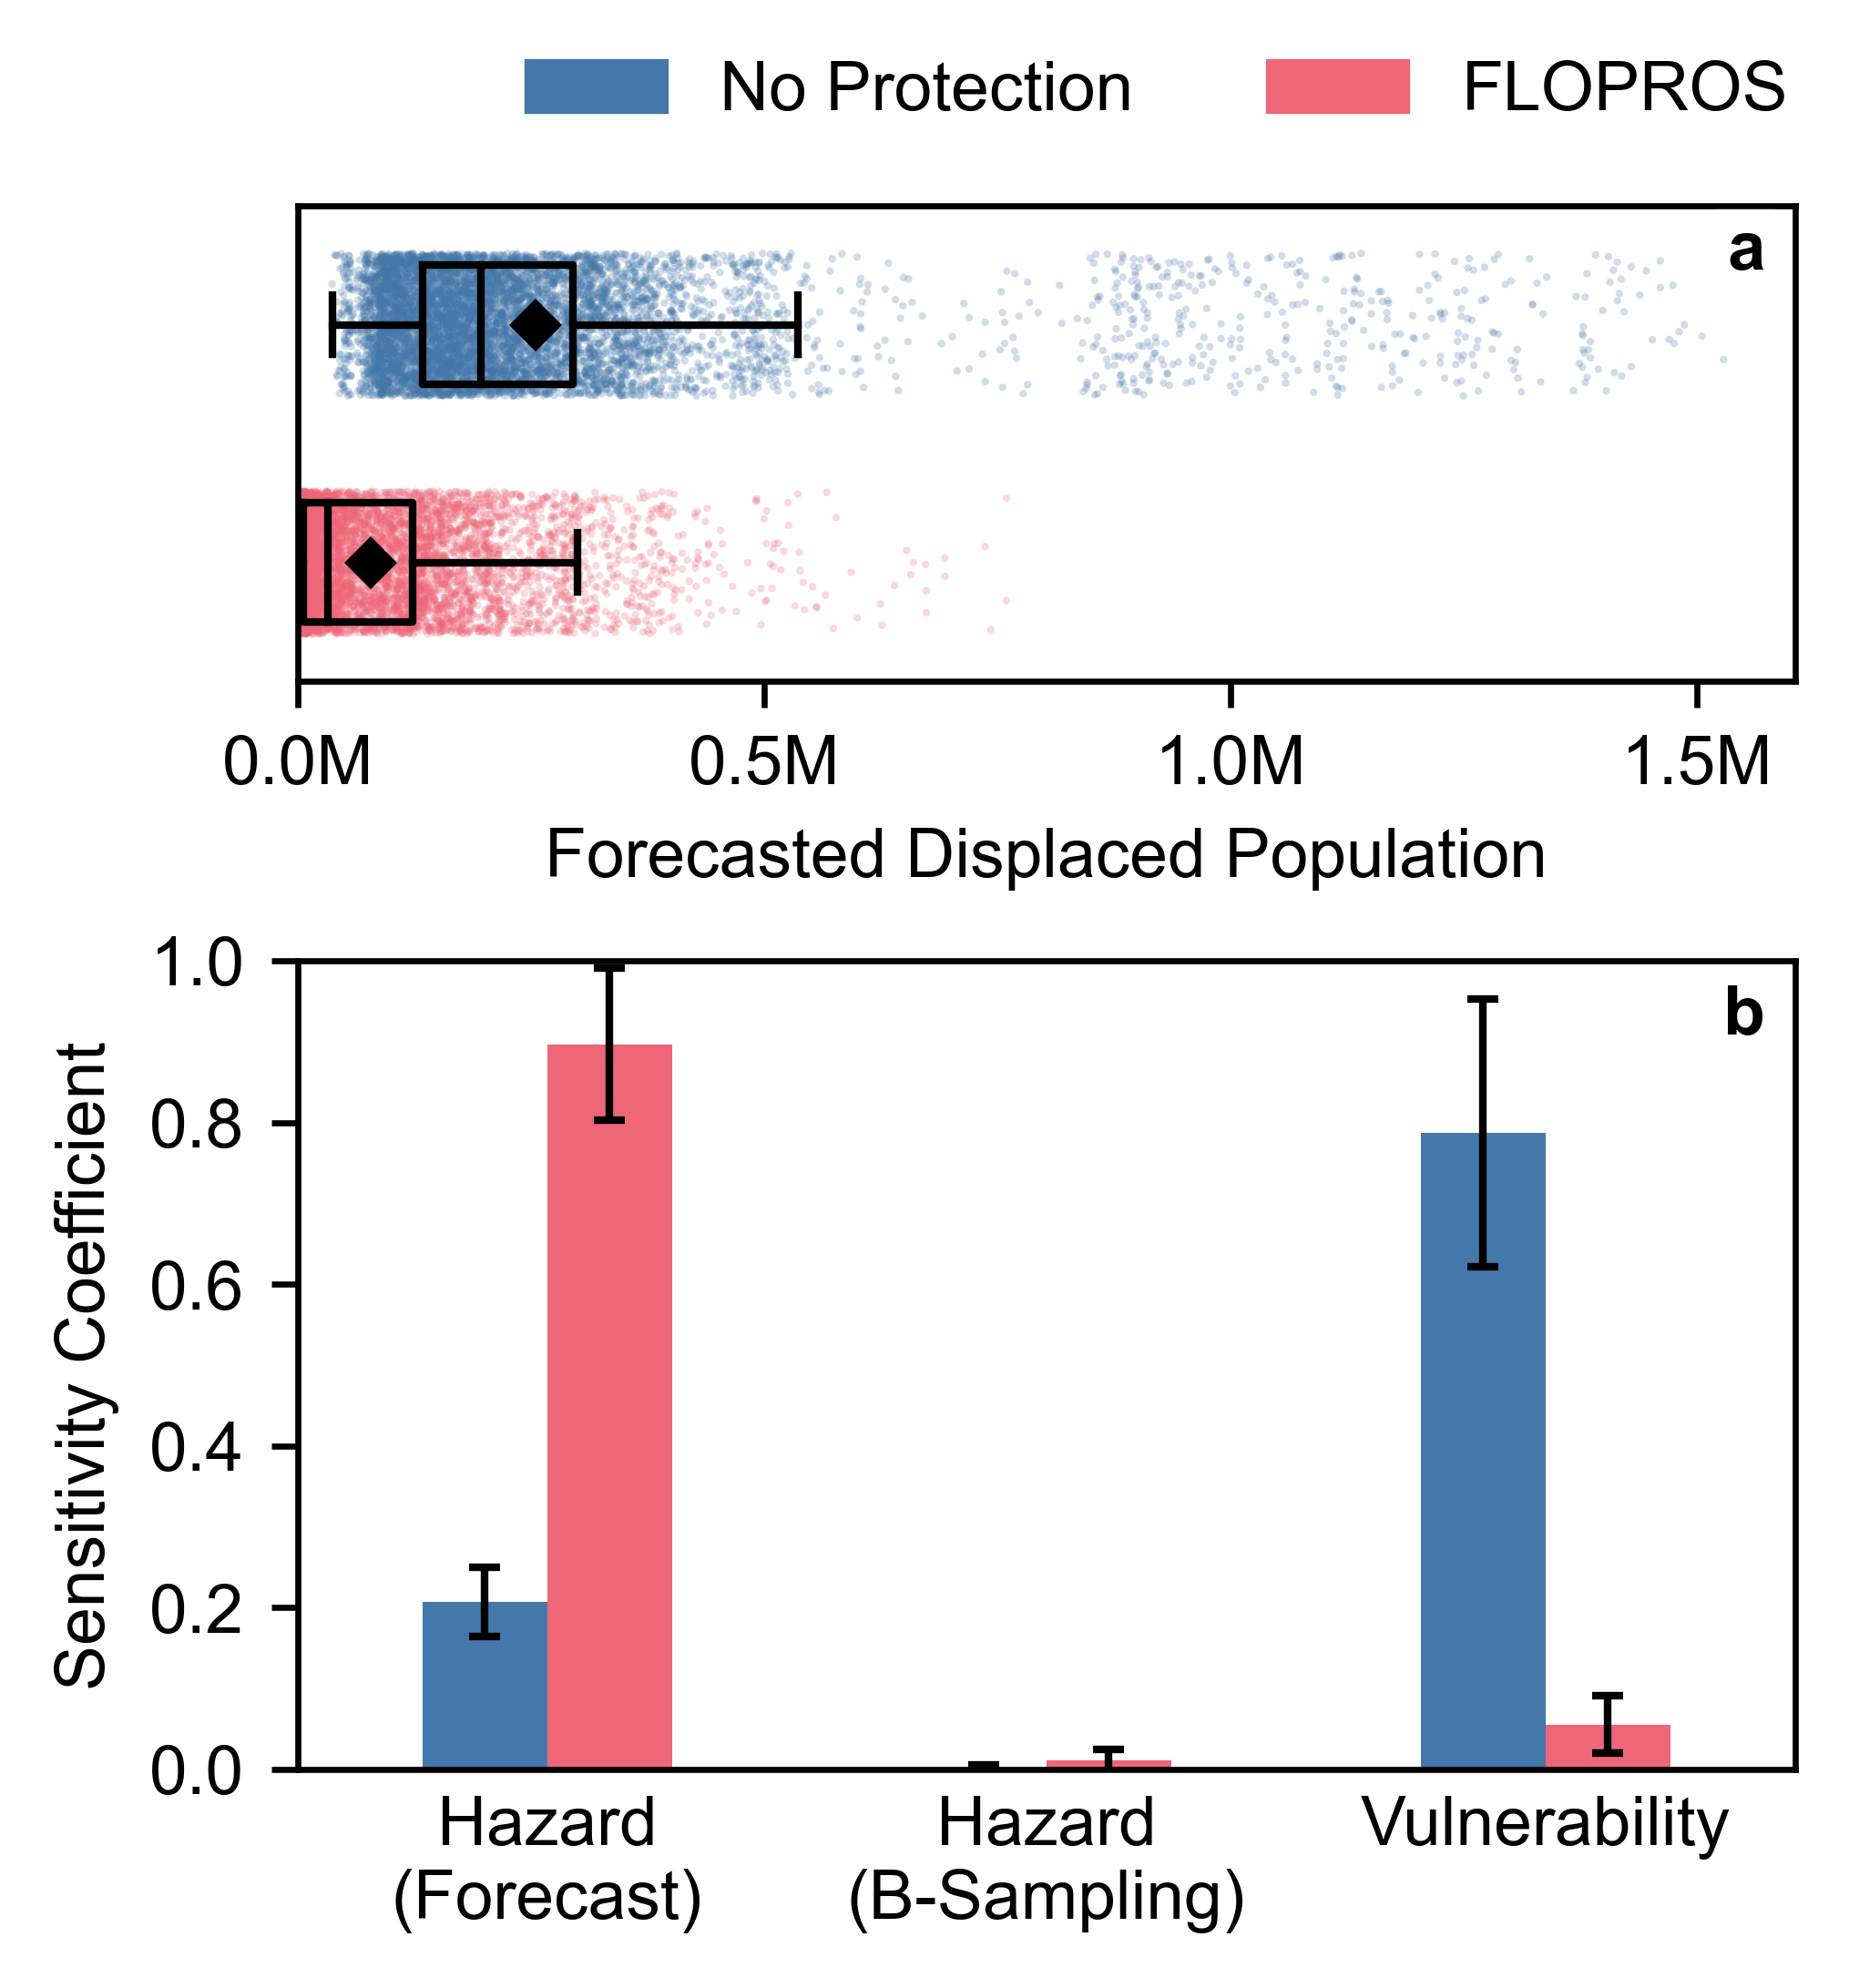

In [58]:
plot_unsequa(DATA_GEN_DIR / "unsequa-230708.h5", "forecast-sensitivity.pdf")


In [10]:
path = DATA_GEN_DIR / "unsequa-230708.h5"

# Merge data
files = [path, path.with_stem(path.stem + "-flopros")]
labels = ["No Protection", "FLOPROS"]

for file, label in zip(files, labels):
    print(
        pd.concat(
            [
                UncOutput.from_hdf5(file)
                .get_sensitivity("S1")
                .set_index("param")["aai_agg"]
                .reindex(["member", "sample", "IL"])
                .rename("S1"),
                UncOutput.from_hdf5(file)
                .get_sensitivity("S1_conf")
                .set_index("param")["aai_agg"]
                .reindex(["member", "sample", "IL"])
                .rename("S1_conf"),
            ],
            axis=1,
        ).round(3)
    )


           S1  S1_conf
param                 
member  0.207    0.042
sample  0.002    0.004
IL      0.787    0.165
           S1  S1_conf
param                 
member  0.897    0.094
sample  0.011    0.013
IL      0.056    0.035


In [11]:
impact = pd.concat([UncOutput.from_hdf5(file).get_uncertainty()["aai_agg"].rename(label) for file, label in zip(files, labels)], axis=1)
impact


No Protection        FLOPROS
0     352536.276252  252230.087941
1     621240.096399  541905.056887
2     395389.619339  306051.250869
3     126062.743523    4618.760579
4     140331.032175    4783.596368
...             ...            ...
8187  137607.034055    3272.655675
8188  139117.961513    3258.897116
8189   82526.089272    3061.616504
8190   96601.080303    2828.676270
8191   84728.396300    2950.432048

[8192 rows x 2 columns]

In [12]:
from matplotlib.cbook import boxplot_stats
stats = boxplot_stats(impact.to_numpy())
for itm in stats:
    itm.pop("fliers")
pd.DataFrame.from_records(stats, index=impact.columns)


mean            iqr           cilo           cihi  \
No Protection  255211.431625  161089.031527  193162.712420  198751.281798   
FLOPROS         77958.944398  117740.497233   30099.199659   34183.903199   

                      whishi        whislo             q1            med  \
No Protection  536049.024501  36796.488496  133370.469864  195956.997109   
FLOPROS        299524.847566      0.000000    5500.957608   32141.551429   

                          q3  
No Protection  294459.501391  
FLOPROS        123241.454841

### Plot Displacement Forecast Time Series

In [3]:
from itertools import product

from climada.engine.unsequa import UncOutput

paths = [
    DATA_GEN_DIR / "unsequa-230706.h5",
    DATA_GEN_DIR / "unsequa-230707.h5",
    DATA_GEN_DIR / "unsequa-230708.h5",
]
dates = pd.date_range("2023-07-06", "2023-07-08")
labels = ["No Protection", "FLOPROS"]


def load_single(filepath, protection, date):
    return pd.DataFrame.from_dict(
        {
            "Forecasted Displaced Population": UncOutput.from_hdf5(
                filepath
            ).get_uncertainty()["aai_agg"],
            "Protection": protection,
            "Forecast Date": date,
        }
    )


dfs = []
for path, date in zip(paths, dates):
    files = [path, path.with_stem(path.stem + "-flopros")]
    for file, label in zip(files, labels):
        dfs.append(load_single(file, protection=label, date=date))

samples = pd.concat(dfs, ignore_index=True)


/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_11051/3499488613.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(
/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_11051/3499488613.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(


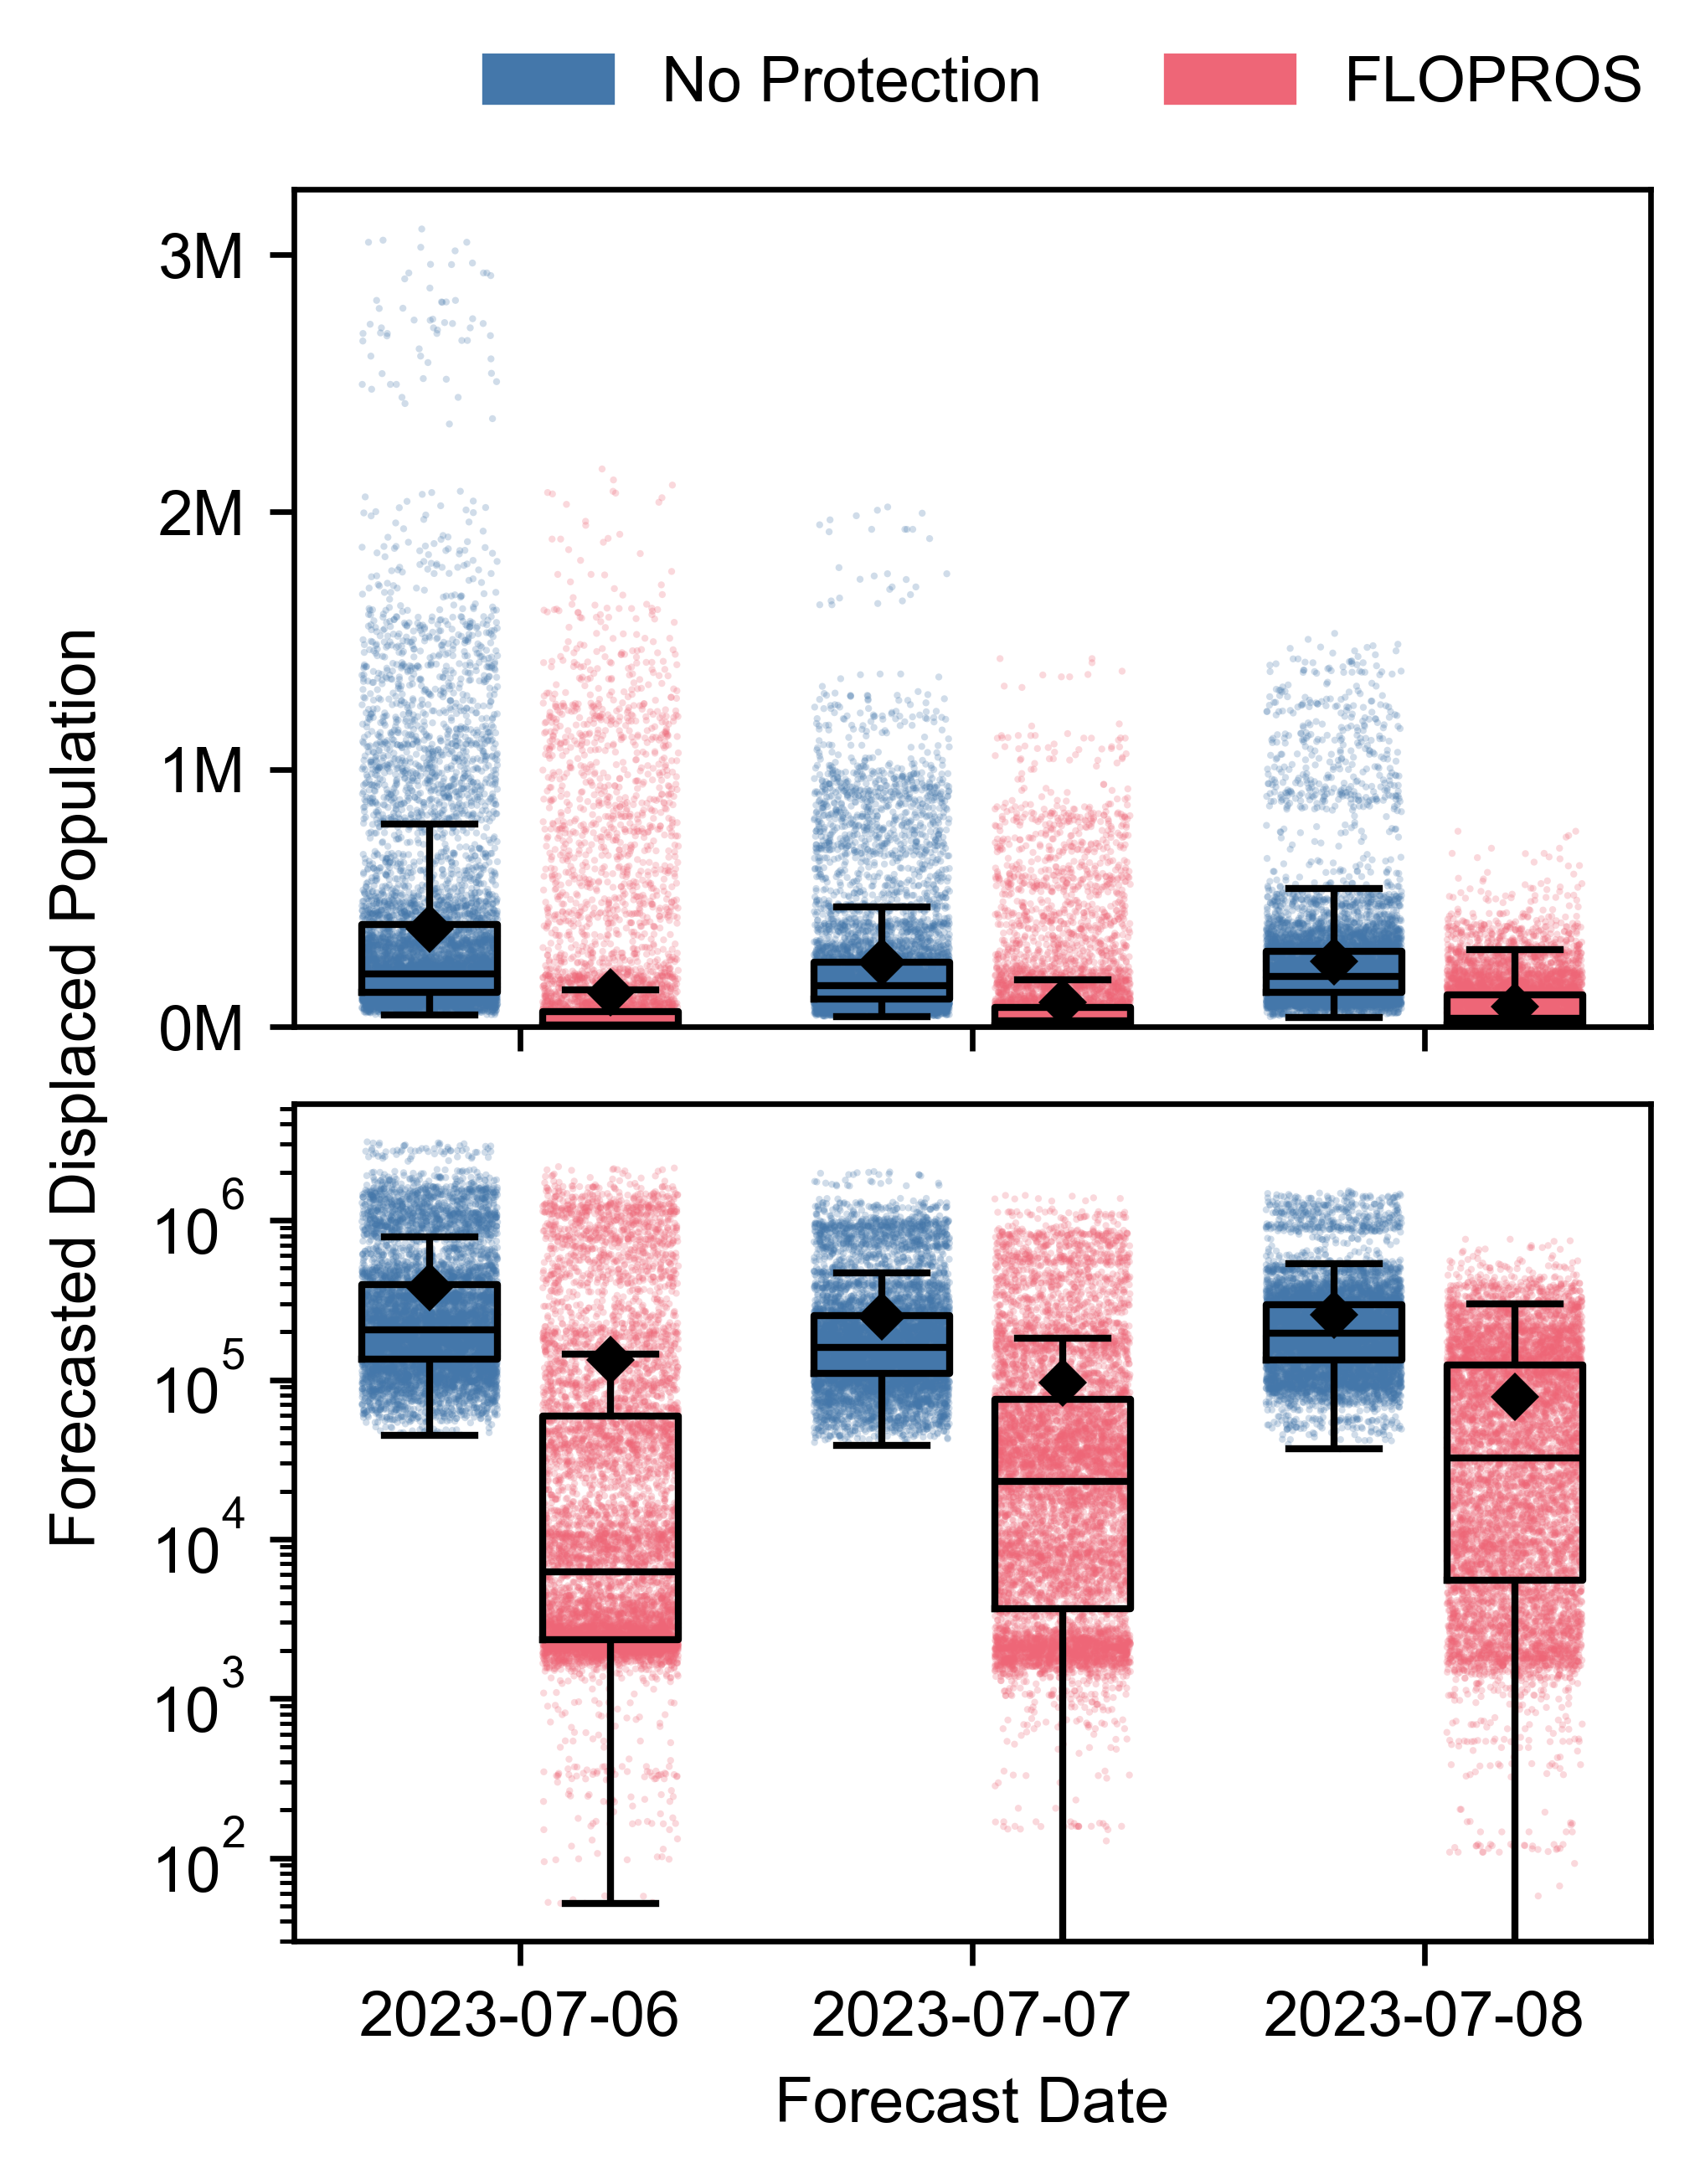

In [4]:
import seaborn as sns

fig, axes = plt.subplots(
    2, 1, sharex=True, figsize=(FIG_WIDTH_ONE_COL, FIG_HEIGHT * 1.2)
)

for ax in axes:
    sns.boxplot(
        ax=ax,
        data=samples,
        x="Forecast Date",
        y="Forecasted Displaced Population",
        hue="Protection",
        fill=False,
        color="black",
        zorder=2,
        showfliers=False,
        showmeans=True,
        widths=0.3,
        linewidth=1.0,
        # meanline=True,
        # patch_artist=True,
        boxprops=dict(color="black"),
        capprops=dict(color="k"),
        whiskerprops=dict(color="k"),
        medianprops=dict(color="k"),
        meanprops=dict(mfc="k", mec="none", marker="D", markersize=5),
        legend=False,
        # log_scale=True,
    )

    sns.stripplot(
        ax=ax,
        data=samples,
        x="Forecast Date",
        y="Forecasted Displaced Population",
        hue="Protection",
        dodge=True,
        jitter=0.3,
        size=1,
        linewidth=0,
        alpha=0.25,
        zorder=1,
        legend=False,
        rasterized=True,
        # log_scale=True,
    )

    ax.set_ylabel("")

# Legend
fig.legend(
    handles=[
        mpatches.Patch(color=color, label=label)
        for color, label in zip(["C0", "C1"], ["No Protection", "FLOPROS"])
    ],
    loc="outside upper right",
    frameon=False,
    ncol=2,
)

fig.supylabel("Forecasted Displaced Population", fontsize="medium")

axes[0].set_ylim(bottom=0)
axes[0].yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{(x / 1e6):.0f}M")
)

axes[1].set_yscale("log")

fig.savefig("forecast-series-uncertainty.pdf")


In [6]:
samples


Forecasted Displaced Population     Protection Forecast Date
0                        268533.220927  No Protection    2023-07-06
1                        479020.456657  No Protection    2023-07-06
2                        257944.185672  No Protection    2023-07-06
3                        888559.041002  No Protection    2023-07-06
4                        870155.286020  No Protection    2023-07-06
...                                ...            ...           ...
49147                      3272.655675        FLOPROS    2023-07-08
49148                      3258.897116        FLOPROS    2023-07-08
49149                      3061.616504        FLOPROS    2023-07-08
49150                      2828.676270        FLOPROS    2023-07-08
49151                      2950.432048        FLOPROS    2023-07-08

[49152 rows x 3 columns]

In [8]:
for prot in samples["Protection"].unique():
    for date in samples["Forecast Date"].unique():
        data = samples.loc[(samples["Protection"] == prot) & (samples["Forecast Date"] == date), "Forecasted Displaced Population"]
        print(prot, date, data.mean(), data.median(), sep="\t")

No Protection	2023-07-06 00:00:00	379511.74612064415	204749.40434030112
No Protection	2023-07-07 00:00:00	249522.66365880717	159066.47582961756
No Protection	2023-07-08 00:00:00	255211.43162479185	195956.99710901553
FLOPROS	2023-07-06 00:00:00	133177.72722610016	6250.702245332652
FLOPROS	2023-07-07 00:00:00	95659.24605078842	22948.476305648383
FLOPROS	2023-07-08 00:00:00	77958.94439818634	32141.55142885323


In [ ]:
from matplotlib.cbook import boxplot_stats
stats = boxplot_stats(impact.to_numpy())
for itm in stats:
    itm.pop("fliers")
pd.DataFrame.from_records(stats, index=impact.columns)


In [14]:
UncOutput.from_hdf5(paths[0]).get_sensitivity("S1_conf")


si   param param2   aai_agg
0  S1_conf      IL   None  0.084169
1  S1_conf  sample   None  0.003157
2  S1_conf  member   None  0.086528

In [28]:
# def load_single_sensitivity(path, sensitivity, protection, date):
#     df = UncOutput.from_hdf5(path).get_sensitivity(sensitivity)
#     df["Forecast Date"] = date
#     df["Protection"] = protection
#     return df


# df_values = []
# df_err = []
# for path, date in zip(paths, dates):
#     files = [path, path.with_stem(path.stem + "-flopros")]
#     for file, label in zip(files, labels):
#         df_values.append(
#             load_single_sensitivity(path, "S1", protection=label, date=date)
#         )
#         df_err.append(
#             load_single_sensitivity(path, "S1_conf", protection=label, date=date)
#         )

# df_values = pd.concat(df_values, ignore_index=True)
# df_err = pd.concat(df_err, ignore_index=True)

df_values = pd.concat(
        [
            UncOutput.from_hdf5(file)
            .get_sensitivity("S1")
            .set_index("param")["aai_agg"]
            .reindex(["member", "sample", "IL"])
            .rename(label)
            for file, label in zip(paths, dates)
        ],
        axis=1,
    )
df_err = pd.concat(
    [
        UncOutput.from_hdf5(file)
        .get_sensitivity("S1_conf")
        .set_index("param")["aai_agg"]
        .reindex(["member", "sample", "IL"])
        .rename(label)
        for file, label in zip(paths, dates)
    ],
    axis=1,
)

df_values_flopros = pd.concat(
        [
            UncOutput.from_hdf5(file.with_stem(file.stem + "-flopros"))
            .get_sensitivity("S1")
            .set_index("param")["aai_agg"]
            .reindex(["member", "sample", "IL"])
            .rename(label)
            for file, label in zip(paths, dates)
        ],
        axis=1,
    )
df_err_flopros = pd.concat(
    [
        UncOutput.from_hdf5(file.with_stem(file.stem + "-flopros"))
        .get_sensitivity("S1_conf")
        .set_index("param")["aai_agg"]
        .reindex(["member", "sample", "IL"])
        .rename(label)
        for file, label in zip(paths, dates)
    ],
    axis=1,
)
df_values


2023-07-06  2023-07-07  2023-07-08
param                                     
member    0.567626    0.477983    0.207112
sample    0.000915    0.000615    0.001652
IL        0.347902    0.523269    0.787447

In [40]:
df_values.columns.tolist()


[Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-07 00:00:00'),
 Timestamp('2023-07-08 00:00:00')]

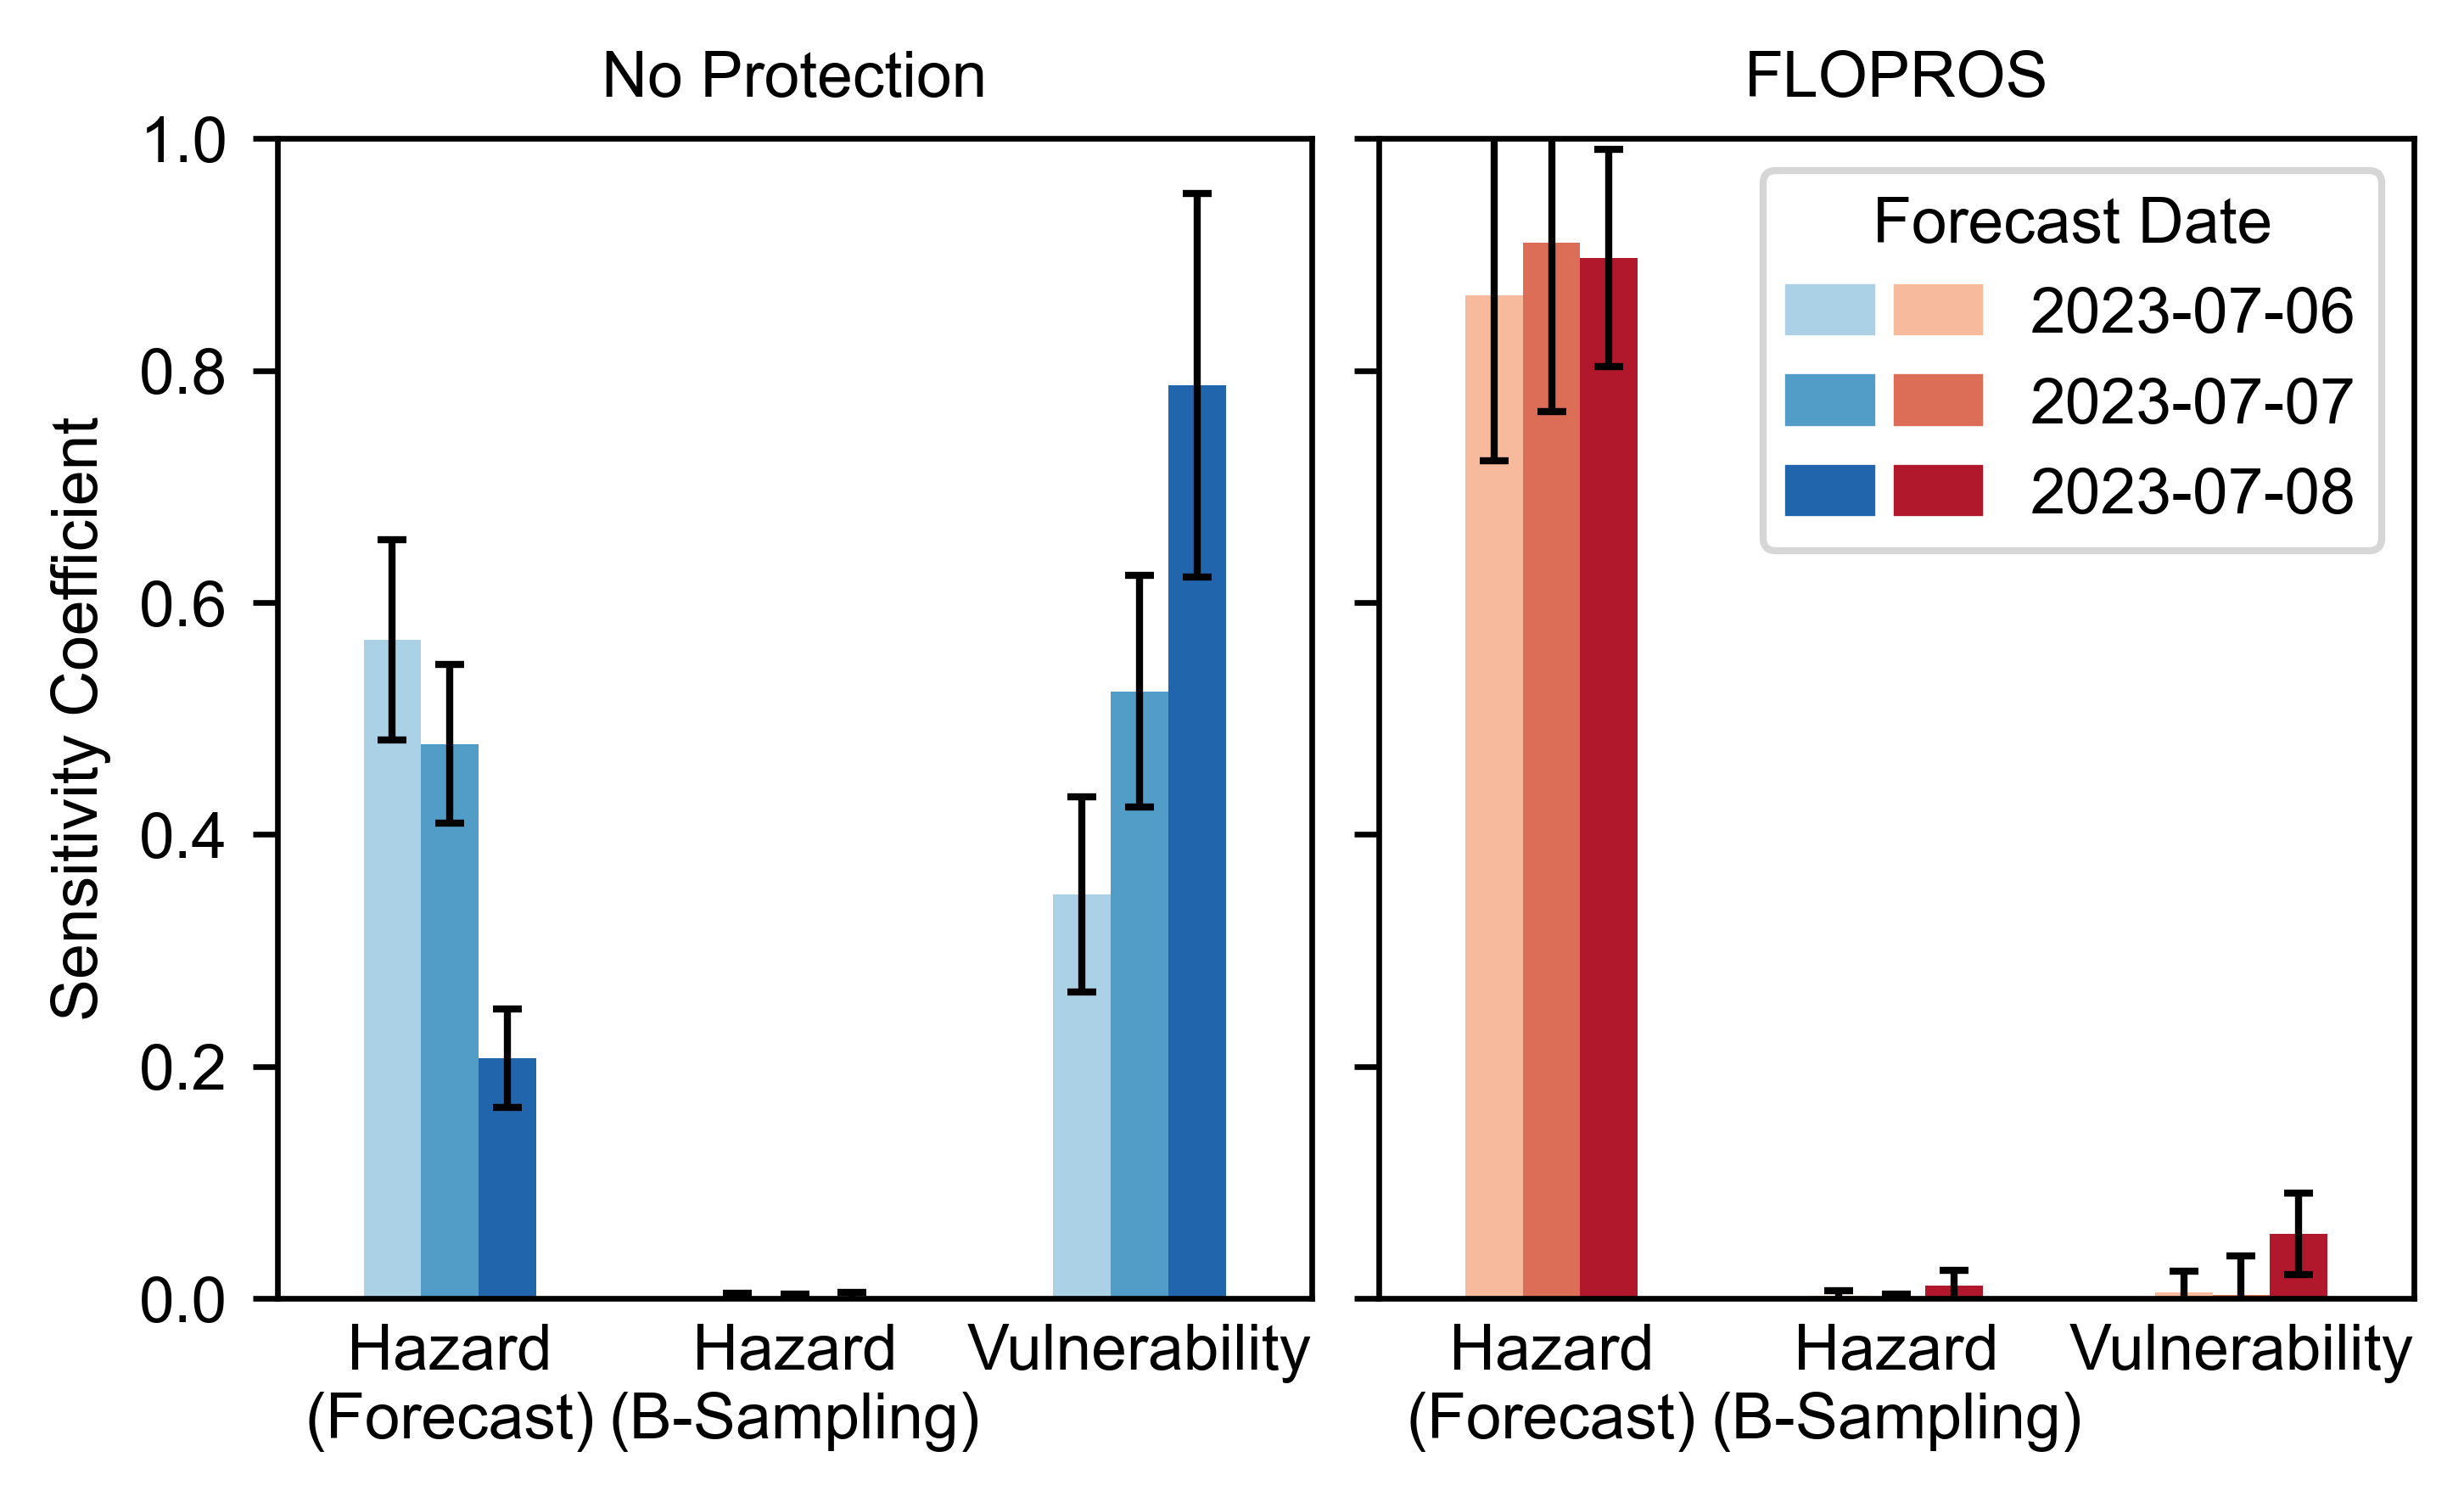

In [55]:
fig, axes = plt.subplots(
    1, 2, sharey=True, figsize=(FIG_WIDTH_TWO_COL, FIG_HEIGHT * 0.8)
)

cmap = tol_colors.tol_cmap("BuRd")
steps = np.flip(np.linspace(0, 0.3, 3))
blues = cmap(steps)
reds = cmap(1 - steps)

df_values.plot.bar(
    ax=axes[0],
    yerr=df_err,
    rot=0,
    capsize=2,
    ecolor="black",
    error_kw=dict(lw=1),
    legend=False,
    color=blues,
)
df_values_flopros.plot.bar(
    ax=axes[1],
    yerr=df_err_flopros,
    rot=0,
    capsize=2,
    ecolor="black",
    error_kw=dict(lw=1),
    legend=False,
    color=reds,
)

axes[0].set_ylabel("Sensitivity Coefficient")
axes[0].set_ylim(bottom=0, top=1)
axes[0].set_title("No Protection")
axes[1].set_title("FLOPROS")

for ax in axes:
    ax.set_xticklabels(["Hazard\n(Forecast)", "Hazard\n(B-Sampling)", "Vulnerability"])
    ax.set_xlabel("")
    ax.tick_params(axis="x", bottom=False, pad=0)

axes[1].legend(
    title="Forecast Date",
    handles=[
        (mpatches.Patch(color=bb), mpatches.Patch(color=rr))
        for bb, rr in zip(blues, reds)
    ],
    labels=[col.date().isoformat() for col in df_values.columns.tolist()],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    handlelength=3,
)

fig.savefig("forecast-series-sensitivity.pdf")


## Plot expected impact map

Only use one sample because influence of samples is negligible anyway.

In [32]:
from climada.engine import ImpactCalc
from climada.entity import ImpactFunc, ImpactFuncSet
from climada_petals.hazard.rf_glofas import hazard_series_from_dataset

def compute_impacts(hazard, impf_data):
    exp.assign_centroids(hazard)
    df_impf = pd.read_json(impf_data)
    impf_list = [
        ImpactFuncSet(
            [
                ImpactFunc.from_step_impf(
                    haz_type="RF",
                    intensity=(0, row["threshold"], 100),
                    paa=(0, row["paa"]),
                )
            ]
        )
        for _, row in df_impf.iterrows()
    ]

    return [ImpactCalc(exp, impf, hazard).impact() for impf in impf_list]


In [33]:
# Reload hazard because we only need a single bootstrap sample
with xr.open_dataset(
    DATA_GEN_DIR / "pakistan-flood-forecast-2023-07-08.nc", chunks="auto"
) as ds:
    ds_sample = ds.isel(sample=0)
    hazard_single = hazard_series_from_dataset(
        ds_sample,
        intensity="flood_depth",
        event_dim="number",
    )
    hazard_single_flopros = hazard_series_from_dataset(
        ds_sample,
        intensity="flood_depth_flopros",
        event_dim="number",
    )


2024-01-15 17:51:55,525 - climada.hazard.base - WARNING - Failed to read values of 'number' as dates. Hazard.event_name will be empty strings
2024-01-15 17:52:01,418 - climada.hazard.base - WARNING - Failed to read values of 'number' as dates. Hazard.event_name will be empty strings


In [34]:
impacts = compute_impacts(
    hazard_single, DATA_GEN_DIR / "impact_function_cross_calibration.json"
)
impacts_flopros = compute_impacts(
    hazard_single_flopros,
    DATA_GEN_DIR / "impact_function_cross_calibration_flopros.json",
)

In [35]:
from climada.engine import Impact

def expected_impact(impact_list, reduce_func):
    impact = Impact.concat(impact_list, reset_event_ids=True)
    impact.eai_exp = reduce_func(impact.imp_mat.toarray())
    # impact.eai_exp = np.median(impact.imp_mat.toarray(), axis=0)
    impact_exp = impact._build_exp()
    impact_exp.set_geometry_points()
    impact_exp.gdf = impact_exp.gdf.to_crs(PLOT_CRS)
    return impact_exp


In [36]:
from functools import partial
mean = partial(np.mean, axis=0)

impact_exp = expected_impact(impacts, reduce_func=mean)
impact_exp_flopros = expected_impact(impacts_flopros, reduce_func=mean)


2024-01-15 17:54:37,520 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:37,523 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:37,524 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:37,524 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:37,525 - climada.engine.impact - WARNING - The 

2024-01-15 17:54:37,892 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/Users/ldr.riedel/coding/climada_python/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


2024-01-15 17:54:43,520 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:43,521 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:43,522 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:43,522 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:43,522 - climada.engine.impact - WARNING - The 

/Users/ldr.riedel/coding/climada_python/climada/util/coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


In [37]:
impact_exp.gdf["value"].sum()


247623.2640543453

In [38]:
sum(np.mean(Impact.concat(impacts, reset_event_ids=True).imp_mat.toarray(), axis=0))


2024-01-15 17:54:47,840 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:47,841 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:47,842 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:47,842 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2024-01-15 17:54:47,843 - climada.engine.impact - WARNING - The 

2024-01-15 17:54:48,090 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


247623.26405434715

(1179859, 4)
(1179859, 4)
[17265.202018301836, 10162.871841157612]


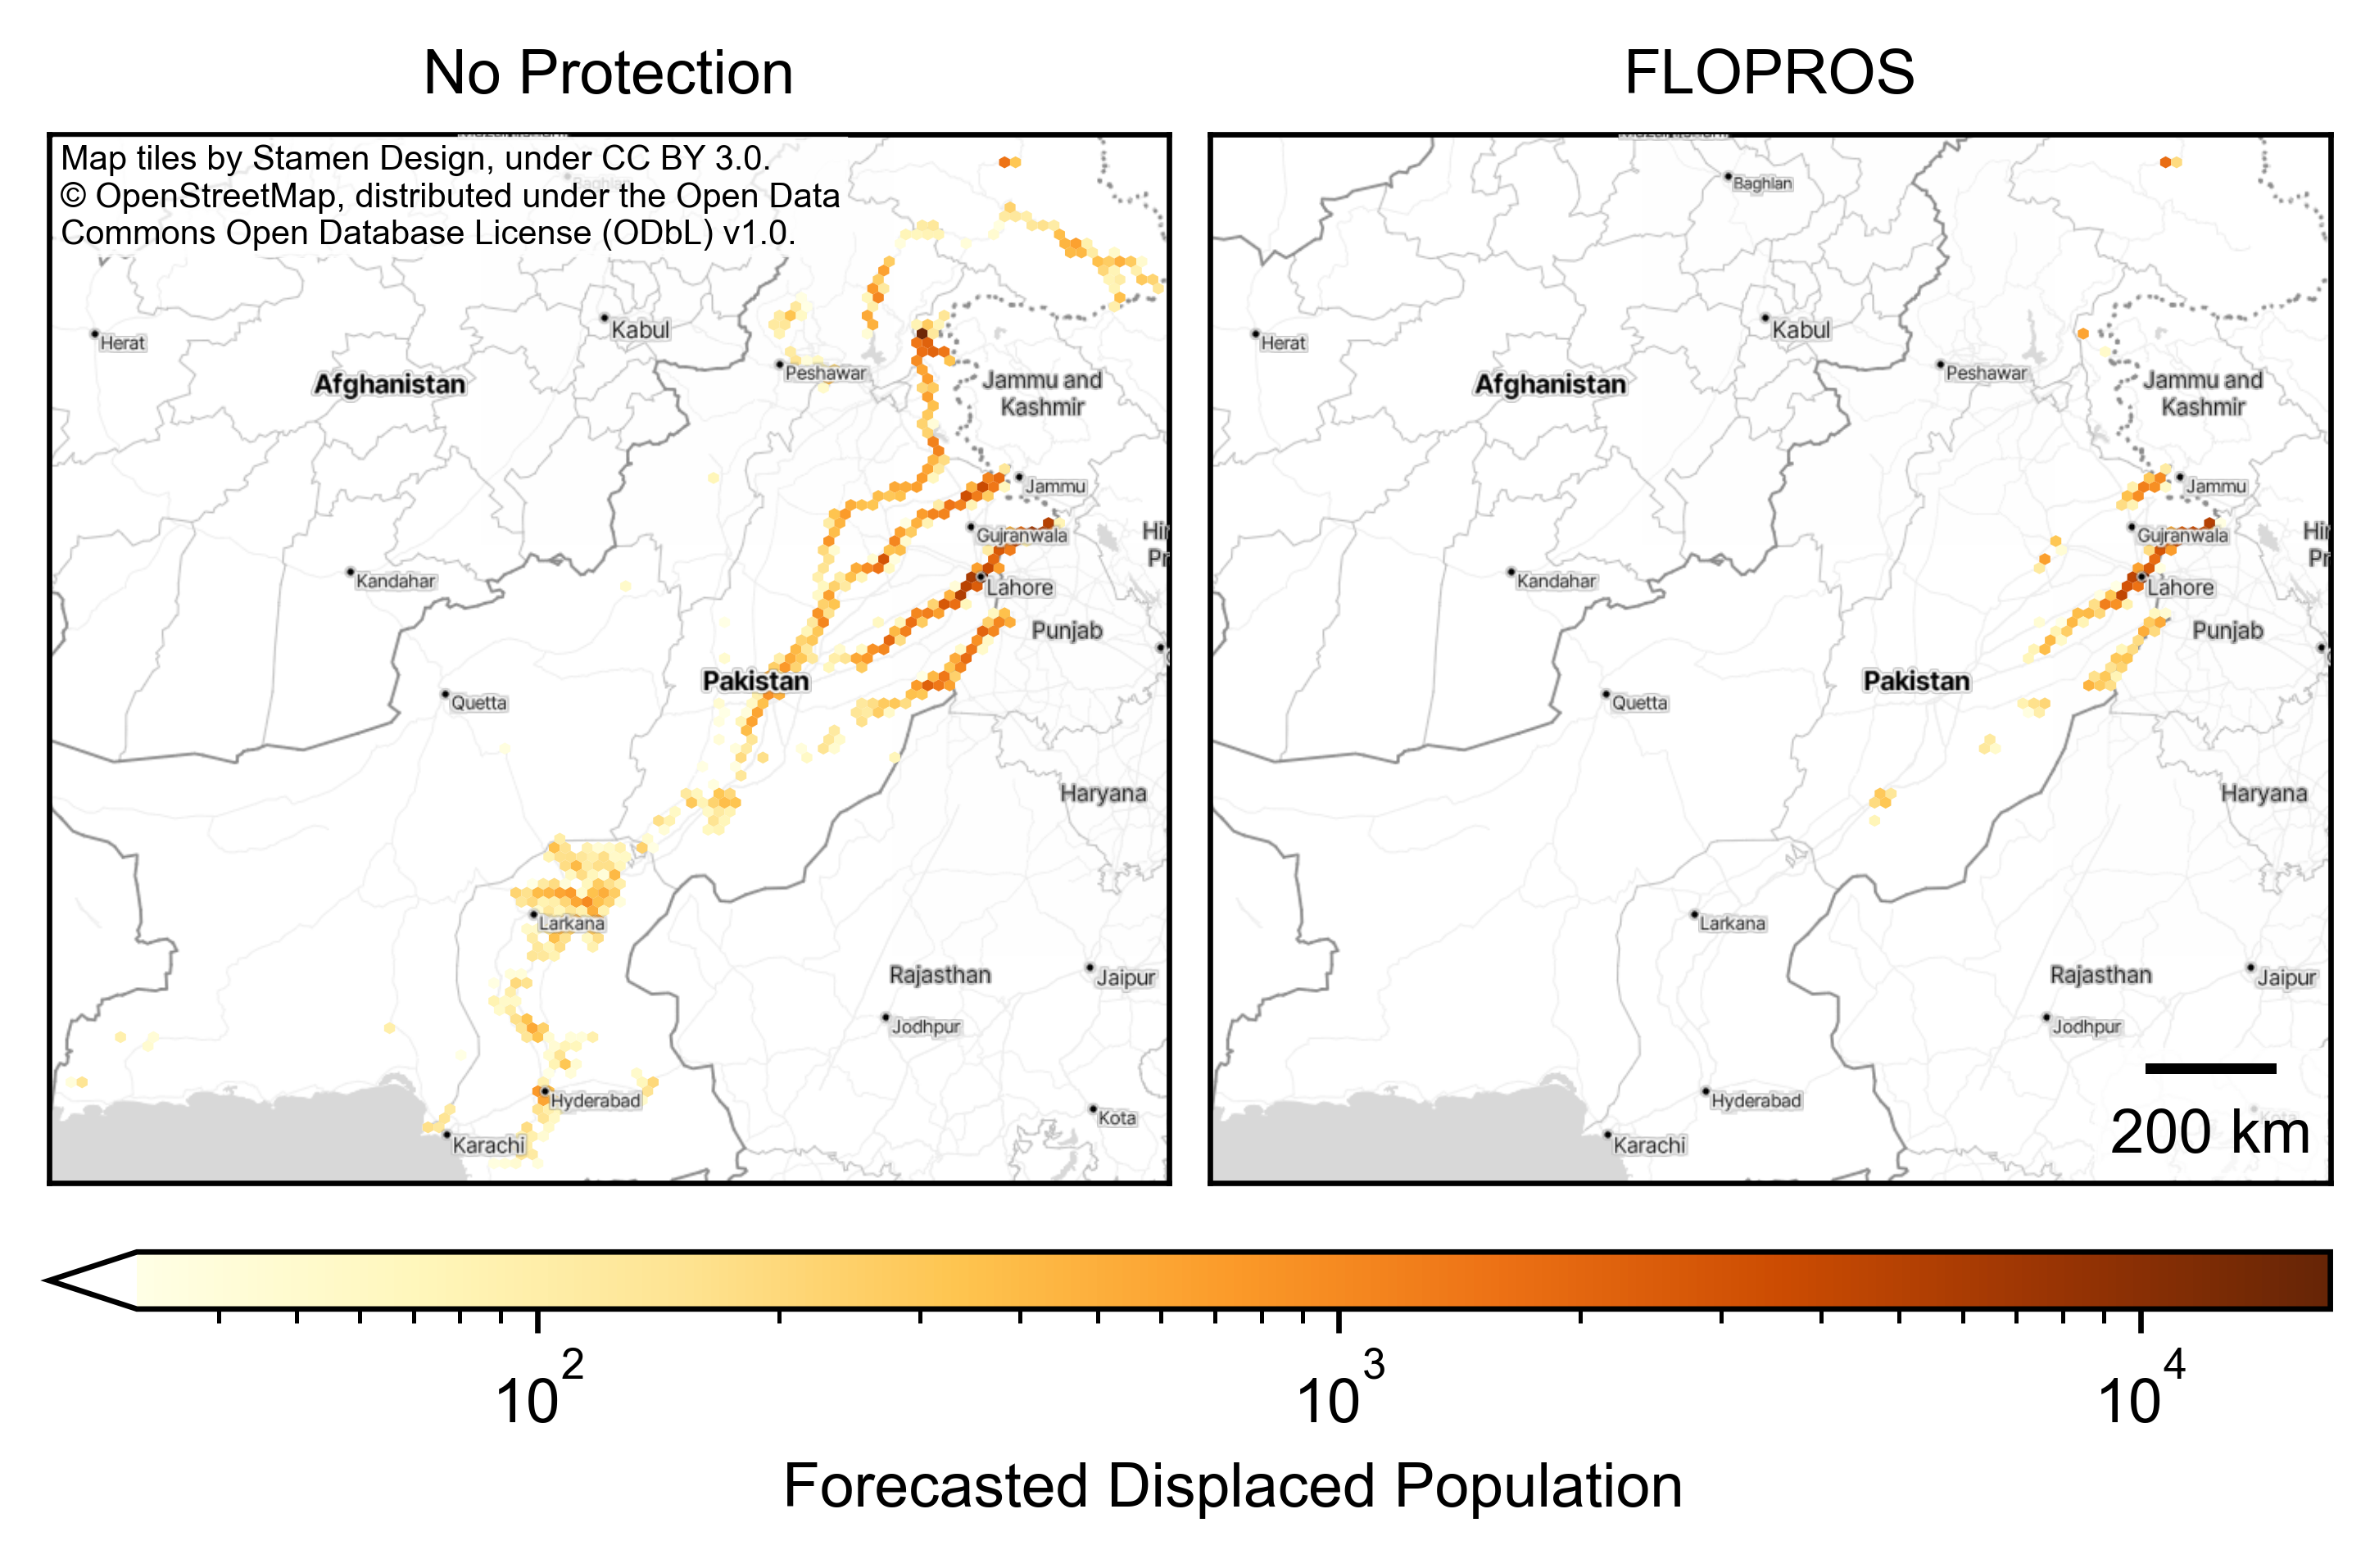

In [39]:
from climada.util.constants import CMAP_IMPACT

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(FIG_WIDTH_TWO_COL, FIG_HEIGHT*0.9))
set_margins(fig)

# impact = impacts[0]
# impact.eai_exp = np.mean([imp.eai_exp for imp in impacts], axis=0)
# impact_exp = impact._build_exp()
# impact_exp.set_geometry_points()
# impact_exp.gdf = impact_exp.gdf.to_crs(PLOT_CRS)
# impact_exp = expected_impact(impacts)

# cmap = CMAP_IMPACT.copy()
# cmap.set_under(cmap.get_bad())

cmap = tol_colors.tol_cmap("YlOrBr").copy()
cmap.set_under(alpha=0)
cmap.set_bad(alpha=0)

vmin = 10 ** 1.5
extent = impact_exp.gdf.geometry.loc[impact_exp.gdf["value"] > 1].total_bounds

def plot(ax, gdf):
    # extent = gdf.geometry.total_bounds
    # gdf = gdf.loc[gdf["value"] > 0]
    print(gdf.shape)
    cm = ax.hexbin(
        x=gdf.geometry.x,
        y=gdf.geometry.y,
        C=gdf["value"],
        reduce_C_function=np.sum,
        gridsize=100,
        extent=(extent[0], extent[2], extent[1], extent[3]),
        lw=0.0,
        cmap=cmap,
        # rasterized=True,
        # norm=mcolors.LogNorm(vmin=1),
    )
    # cm = ax.scatter(
    #     x=gdf.geometry.x,
    #     y=gdf.geometry.y,
    #     c=gdf["value"],
    #     s=0.5,
    #     cmap=cmap,
    #     rasterized=True,
    #     norm=mcolors.LogNorm(vmin=1),
    # )
    # plt.colorbar(cm, ax=ax, orientation="horizontal")
    add_basemap(ax)
    remove_ticks(ax)
    return cm

cms = [plot(ax, imp.gdf) for ax, imp in zip(axes, (impact_exp, impact_exp_flopros))]
vmax = max((cm.get_array().max() for cm in cms))
print([cm.get_array().max() for cm in cms])
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
# norm=mcolors.Normalize(vmin=vmin, vmax=vmax)
for cm in cms:
    cm.set_norm(norm)

plt.colorbar(
    cms[0],
    ax=axes,
    extend="min",
    label="Forecasted Displaced Population",
    orientation="horizontal",
    aspect=40,
    extendfrac=0.04,
)

add_attribution(axes[0], "top")
add_scalebar(axes[1])

axes[0].set_title("No Protection")
axes[1].set_title("FLOPROS")

# remove_ticks(ax)
# add_basemap(ax)
# add_attribution(ax, loc="lower left")

fig.savefig("impact-forecast.pdf")
